# 🤖 LLMからAIエージェントへ

この課題では、4つのステップを通じて、単純な文章生成AIが、どのようにして自律的に思考し、外部の情報を利用する「AIエージェント」に進化するのかを体験します。

全てのステップで、LLMの最も基本的な「与えられた文章の続きを予測する」機能だけを使います。これにより、チャットやReActといった応用機能が、実はこの基本機能の巧みな使い方に過ぎないことを、コードレベルで理解することを目指します。

In [ ]:
# @title ⚙️ステップ0：実行環境の選択と準備
# @markdown ### 👇 LLMの実行環境を選択してください
# @markdown - **OPENROUTER**: (推奨) ColabからOpenRouterのAPIを呼び出します。高速で多様なモデルが利用可能ですが、事前のアカウント・APIキーの登録が必要です。使用回数やモデルによっては有料モデルの使用が必須となります。
# @markdown - **GOOGLE_COLAB**: ColabのGPUを使い、ロードしたモデル（Llama-3ベース）で直接計算します。GPUランタイムの設定が必要です。
# @markdown - **LOCAL_OLLAMA**: ご自身のPCで動いているOllamaサーバーに接続します。（Colabでは使用不可）
ENVIRONMENT = "GOOGLE_COLAB"  #@param ["OPENROUTER", "GOOGLE_COLAB", "LOCAL_OLLAMA"]

import sys, os, requests, json

# --- グローバル変数の初期化 ---
OPENROUTER_API_KEY = None
OLLAMA_HOST = None # LOCAL_OLLAMAモードでユーザーが設定
IS_COLAB = 'google.colab' in sys.modules

# --- 選択された環境に応じたセットアップ ---
if ENVIRONMENT == "OPENROUTER":
    if not IS_COLAB:
        raise RuntimeError("OPENROUTERモードはGoogle Colab環境での使用を想定しています。")
    from google.colab import userdata
    try:
        # ColabのSecrets機能からAPIキーを安全に取得
        OPENROUTER_API_KEY = userdata.get('OPENROUTER_API_KEY')
        print("✅ OpenRouter APIキーをColab Secretsから正常に読み込みました。")
    except userdata.SecretNotFoundError:
        print("❌ ColabにOpenRouterのAPIキーが設定されていません。")
        print("   左パネルの(🔑)アイコンから、名前を 'OPENROUTER_API_KEY' としてキーを登録してください。")
        raise ValueError("APIキーが見つかりません。")

# --- GOOGLE_COLABモードが選択されている場合のみ実行 ---
elif ENVIRONMENT == "GOOGLE_COLAB":
    print("✅ GOOGLE_COLABモードのため、モデルのセットアップを開始します。")

    # GPUが利用可能か確認
    import torch
    from tqdm import tqdm

    if not torch.cuda.is_available():
        raise RuntimeError("❌ GPUが有効になっていません。\n[ランタイム]→[ランタイムのタイプを変更]→[GPU]を選んでください。")
    else:
        print("🚀 GPUを認識しました。")

    # --- ライブラリのインストール ---
    print("🔧 必要なライブラリをインストール中...")
    # -q オプションでインストールログを抑制
    !pip uninstall -y transformers accelerate
    !pip install -q transformers accelerate bitsandbytes

    from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

    # --- モデルの準備 ---
    # Colabの無料GPU（T4など）のメモリに収まるように、モデルを4bitで量子化して読み込みます
    model_id = "elyza/Llama-3-ELYZA-JP-8B"
    print(f"📦 モデル '{model_id}' をHugging Faceからダウンロード・ロードします...")

    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16
    )

    # トークナイザーとモデルをグローバル変数としてロード
    # これにより、後のstream_llm_completion関数から参照できるようになります
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        quantization_config=quantization_config,
        device_map="auto" # 自動的にGPUにモデルを配置
    )

    print("\n✅ モデルの準備が完了しました。")

elif ENVIRONMENT == "LOCAL_OLLAMA":
    if IS_COLAB:
        raise RuntimeError("LOCAL_OLLAMAモードはColab環境では使用できません。ローカル環境で実行してください。")
    OLLAMA_HOST = "http://localhost:11434" # 必要に応じてIPアドレス等を設定
    print(f"✅ ローカルOllamaモードが選択されました。接続先: {OLLAMA_HOST}")

import requests
import json
import time
from tqdm.notebook import tqdm
import torch

# この関数は、事前のセットアップセルが実行された後に定義します。
# GOOGLE_COLABモードの場合、'tokenizer'と'model'がグローバルにロード済みであることが前提です。

def stream_llm_completion(
    prompt_text,
    model_name="deepseek/deepseek-chat-v3-0324:free",
    max_tokens=500,
    temperature=0.7,
    stop=None,
    show_input=True
):
    """
    指定されたプロンプトの続きを生成するために、LLMを呼び出します。
    グローバル変数ENVIRONMENTに応じてプロバイダーを自動で切り替え、
    生成されたテキスト全体を文字列として返します。

    Args:
        prompt_text (str): LLMに渡す入力テキスト。
        model_name (str): 使用するモデル名 (OpenRouter/Ollama用)。
        max_tokens (int): 生成するトークンの最大数。
        temperature (float): 生成のランダム性を制御する値。
        stop (list[str], optional): 生成を停止させる文字列のリスト。Defaults to None.
        show_input (bool, optional): 入力プロンプトを表示するかどうか。Defaults to True.

    Returns:
        str: LLMによって生成された完全なテキスト。
        None: エラーが発生した場合。
    """
    # --- 表示するモデル名を設定 ---
    if ENVIRONMENT == "OPENROUTER":
        display_model = f"OpenRouter ({model_name})"
    elif ENVIRONMENT == "GOOGLE_COLAB":
        display_model = "Local ELYZA Llama-3 (Colab GPU)"
    elif ENVIRONMENT == "LOCAL_OLLAMA":
        display_model = f"Local Ollama ({model_name})"
    else:
        print(f"[エラー] サポートされていないENVIRONMENTです: {ENVIRONMENT}")
        return None

    if show_input:
        print(f"\033[1;32m--- LLM ({display_model}) への入力テキスト ---\033[0m\n{prompt_text}")
    print("\n\033[1;34m--- LLMからの応答 ---\033[0m")

    # 生成されたテキスト全体を格納するための変数を初期化
    full_response_text = ""

    try:
        # --- 1. OpenRouter API を使用 ---
        if ENVIRONMENT == 'OPENROUTER':
            if not OPENROUTER_API_KEY:
                print("[エラー] OpenRouter APIキーが設定されていません。")
                return None

            # 教育上の理由で /completions エンドポイントを維持
            api_url = "https://openrouter.ai/api/v1/completions"
            headers = {
                "Authorization": f"Bearer {OPENROUTER_API_KEY}",
                "Content-Type": "application/json"
            }
            payload = {
                "model": model_name,
                "prompt": prompt_text,
                "temperature": temperature,
                "max_tokens": max_tokens,
                "stream": True
            }
            if stop:
                payload["stop"] = stop if isinstance(stop, list) else [stop]

            response = requests.post(api_url, headers=headers, json=payload, stream=True)
            response.raise_for_status()

            for line in response.iter_lines():
                if line:
                    decoded_line = line.decode('utf-8')
                    if decoded_line.startswith('data: '):
                        json_str = decoded_line[len('data: '):]
                        if json_str.strip() == '[DONE]':
                            break
                        try:
                            data = json.loads(json_str)
                            if 'choices' in data and data['choices']:
                                chunk = data['choices'][0].get('text', '')
                                full_response_text += chunk
                                print(chunk, end='', flush=True)
                        except json.JSONDecodeError:
                            continue
            print() # 最後に改行
            return full_response_text

        # --- 2. Colab GPUでローカルモデルを使用 ---
        elif ENVIRONMENT == 'GOOGLE_COLAB':
            input_ids = tokenizer.encode(prompt_text, return_tensors="pt").to(model.device)
            prompt_token_length = len(input_ids[0])
            generated_ids = input_ids.clone()
            model.eval()

            if isinstance(stop, str):
                stop = [stop]
            stop_token_ids = [tokenizer.convert_tokens_to_ids(s) for s in stop] if stop else []

            with torch.no_grad():
                for _ in tqdm(range(max_tokens), desc="テキスト生成中..."):
                    outputs = model(generated_ids)
                    next_token_logits = outputs.logits[:, -1, :]
                    probs = torch.nn.functional.softmax(next_token_logits / temperature, dim=-1)
                    next_token_id_tensor = torch.multinomial(probs, num_samples=1)
                    next_token_id = next_token_id_tensor.item()
                    if stop_token_ids and next_token_id in stop_token_ids:
                        break
                    generated_ids = torch.cat((generated_ids, next_token_id_tensor), dim=1)

            response_token_ids = generated_ids[0][prompt_token_length:]
            full_response_text = tokenizer.decode(response_token_ids, skip_special_tokens=True)
            print(full_response_text)
            return full_response_text

        # --- 3. ローカルのOllamaサーバーを使用 ---
        elif ENVIRONMENT == 'LOCAL_OLLAMA':
            if not OLLAMA_HOST:
                 print("[エラー] Ollamaのホストが設定されていません。")
                 return None
            api_url = f"{OLLAMA_HOST}/api/generate"
            headers = {"Content-Type": "application/json"}
            payload = {
                "model": model_name, "prompt": prompt_text, "stream": True,
                "options": {"temperature": temperature, "num_predict": max_tokens}
            }
            if stop:
                payload["options"]["stop"] = stop if isinstance(stop, list) else [stop]

            response = requests.post(api_url, headers=headers, json=payload, stream=True)
            response.raise_for_status()

            for line in response.iter_lines():
                if line:
                    try:
                        data = json.loads(line.decode('utf-8'))
                        chunk = data.get('response', '')
                        full_response_text += chunk
                        print(chunk, end='', flush=True)
                        if data.get('done'):
                            break
                    except json.JSONDecodeError:
                        continue
            print() # 最後に改行
            return full_response_text

    except requests.exceptions.RequestException as e:
        print(f"\n[エラー] APIリクエストに失敗しました: {e}")
        return None
    except Exception as e:
        print(f"\n[エラー] 予期せぬエラーが発生しました: {e}")
        return None

## 📝ステップ1：LLMの基本機能「続きの文章を予測する」を体験する

LLMの最も核となる能力は、与えられた文章に続く確率が最も高い単語を次々と予測し、文章を生成することです。ここでは、物語の冒頭部分をLLMに渡し、その「続き」をリアルタイムで生成させます。

`stream_llm_completion()` はLLMがどのように文章をつないでいくかを直接観察するための関数です。

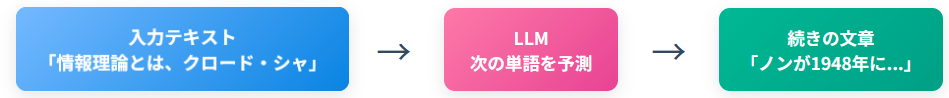

In [ ]:
# @title 単純に続きを書かせる
prompt_text = "情報理論とは、クロード・シャ" # @param {"type":"string"}
stream_llm_completion(prompt_text, max_tokens=70)
print()

**課題📖**

プロンプトの冒頭（`prompt_text`）を「昔々あるところに、」に変更し、LLMに物語の続きを創作させてみましょう 。

---
## 💬ステップ2：応用機能「チャットボット」の仕組みを体験する

普段私たちが利用するチャットボットは、LLMに特別な「対話モード」があるわけではありません。実は、会話のやり取りを、LLMが得意な特定のフォーマットを持つ **一つの長い文章（平文）** に変換し、その「続き」を書かせているだけです。

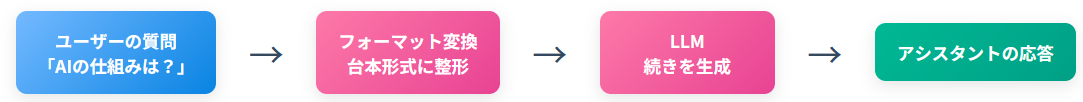

In [ ]:
# @title 台本形式をつくる
question = "今日は暑いですね。" # @param {"type":"string"}
conversation_prompt = f'''あなたは優秀で親切なアシスタントです。
ユーザ: {question}
システム:
'''
print(conversation_prompt)

---
プロンプトが確認できたところで、続きを書かせてみましょう。

In [ ]:
# @title　続きをLLMに書かせる
output = stream_llm_completion(conversation_prompt, max_tokens=100)
print(output)

---
このように、ドラマの台本のような会話形式を用いることで、質問と回答の「続きを書く」ことができます。ただし、一般的には以下のように、**ロール**（誰として振る舞うか）や**コンテンツ**（メッセージ本体）などの形式を整えて、記号で区切って与えます。

- `[INST]` と `[/INST]`

    意味: Instruction（インストラクション＝指示）の略です。

    役割: 人間がAIに与える「指示」や「質問」の全体を囲みます。「ここからここまでが人間からの1回分の入力ですよ」とAIに教えています。

- `<<SYS>>` と `<</SYS>>`

    意味: System（システム）の略です。

    役割: [INST]ブロックの内部で使われ、AIの基本的な**役割、前提条件、人格などを設定する「システムプロンプト」**を囲みます。「今回の指示に答えるにあたって、あなたはこの役割を演じてくださいね」という、より根本的な指示を与える部分です。

では実行してみましょう。

In [ ]:
# @title ``[INST]`` や ``<<SYS>>`` を用いた実行形式
# 1. 人間にとって分かりやすい会話データ
messages = [
    {"role": "system", "content": "あなたは親切なアシスタントです。"},
    {"role": "user", "content": "AI の仕組みがわかりません。どうやって勉強したらいいですか？"}
]

# 2. LLMに渡すための「ただの文章」に変換する
system_prompt = messages[0]['content']
user_prompt = messages[1]['content']
formatted_prompt = f"[INST] <<SYS>>\n{system_prompt}\n<</SYS>>\n\n{user_prompt} [/INST]"

print("\033[1;32m--- LLMへの入力テキスト ---\033[0m\n")
print(formatted_prompt)
# 3. 整形された文章の「続き」をLLMに書かせる
stream_llm_completion(formatted_prompt, max_tokens=100)

**課題💬**

`messages` 内のユーザーの質問を「日本の首都はどこですか？」に変更し、アシスタントの応答を確かめてみましょう。

---
## 🧠 ステップ3：思考への発展 "考えてから答える"

**（注）Google Colab 上の GPU で使用できる LLM では能力に限界があり、ここからの課題を実行することはお勧めしません**

より複雑な質問に答えるために、LLMにまず「思考プロセス」を生成させ、その後に結論を導き出させます。これもステップ2と同様に、「思考プロセスを書きなさい」という指示を含んだ文章を作り、その続きをLLMに書かせることで実現します。これにより、LLMがどのように段階的に推論を進めるかを見ることができます。

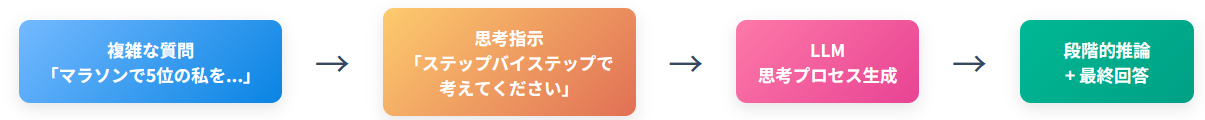

まずは、単なる質問・回答の形式で見てみましょう。

In [ ]:
message = "私はマラソンで4位です。後ろの人が追いつきました。あなたは何位ですか？" # @param {"type":"string"}
question = f'''[INST] <<SYS>>
あなたは親切な日本人のアシスタントです。
<</SYS>>

{message}[/INST]'''

prompt_text = f"""
質問: {question}
回答:
"""

if ENVIRONMENT == "GOOGLE_COLAB":
  print("\033[1;31mGoogle Colab 上の GPU を使用しているため、ここからの課題に取り組む能力が十分ではありません。\nOpenRouter の利用をご検討ください。授業での利用（同時に数十人がアクセスする）ではなく個人での利用ならば、無料のモデルでも試せるはずです。\033[0m")

# LLMに思考プロセスと結論を生成させる
stream_llm_completion(prompt_text, max_tokens=300)

---
続いて、「ステップバイステップで」と指示を出し、思考プロセスも書かせる方法を使ってみましょう。

In [ ]:
# @title
prompt_text = f"""
質問: {question}
日本語でステップバイステップで考えて、最後に結論を出してください。
思考プロセス:
"""

# LLMに思考プロセスと結論を生成させる
stream_llm_completion(prompt_text, max_tokens=500)


 **課題🧠**

`question` のりんごの問題を「5たす3ひく2は？」といった簡単な計算問題に変更し、LLMが正しく思考できるか試してみましょう。

1.   リスト項目
2.   リスト項目


---
## 🔄ステップ4：ReActで「自律的」なAIエージェントを作る

最後のステップでは、これまでの知識を総動員して、LLMを単なる応答マシンから、**目的を達成するために自ら考えて行動する「AIエージェント」**へと進化させます。そのための設計思想が**ReAct**です。

### LLMの限界と、ReActが生まれた背景

ステップ1〜3で見てきたように、LLMは優れた言語能力を持っていますが、それだけでは解決できない根本的な弱点があります。

1.  **知識が古い**: LLMの知識は、学習した時点の情報で「凍結」されています。「昨日のニュースは？」と聞かれても答えられません。
2.  **外部世界にアクセスできない**: インターネットで検索したり、計算機を使ったり、あなたのPCのファイルを開いたりはできません。
3.  **論理・計算が苦手**: 複雑な計算や、厳密な論理的推論を間違えることがあります。

これらの弱点を克服し、LLMの高度な「思考能力」と、コンピュータの正確な「実行能力」を結びつけるために考案されたのが、**ReAct (Reason + Act)** というフレームワークです。

### 「AIエージェント」と「自律性」とは？

-   **AIエージェント (Agent)** とは、単に質問に答えるだけでなく、**与えられた目標を達成するために、周囲の状況を観察し、自ら行動を選択できるAI**のことです。
-   **自律性 (Autonomy)** とは、この文脈では「AIが意識を持つ」といったSF的な話ではありません。**「次に何をすべきか」を、外部からの指示なしに、自分自身の思考プロセスに基づいて決定できる能力**を指します。

ReActは、`思考 → 行動 → 観察` というサイクルを回すことで、この「自律性」を擬似的に実現します。LLM自身が「目標達成のためには、次はこのツールを使うべきだ」と**自ら判断**し、その結果を見てまた次の行動を決める。この繰り返しが、AIエージェントの自律的な振る舞いの基本です。

### この課題が模倣する「AIエージェントのエッセンス」

このステップ4で行う課題は、非常にシンプルながら、現代の高度なAIエージェントが持つ以下の**本質的な要素（エッセンス）**をすべて含んでいます。

1.  **目標の分解 (Goal Decomposition)**: 「今日の日付を教えて」という最終目標を、「まず現在時刻を調べるツールを使う」という実行可能な小さなステップに分解する能力（`Thought`の部分）。
2.  **ツールの利用 (Tool Use)**: LLM自身が持たない情報を得るために、外部のプログラム（`get_current_datetime`関数）を呼び出すという、最も基本的な行動（`Action`の部分）。
3.  **自己評価と計画修正 (Self-Correction)**: ツールの実行結果（`Observation`）を見て、次の思考を組み立てるプロセス。もしツールがエラーを返せば、別のツールを試すといった計画修正も可能です。

このシンプルな課題を通じて、あなたはAIエージェントの最も根本的な動作原理を、まさに「神の視点（プログラマーの視点）」から体験することになります。

### 準備セル：ツールと最初の指示書を用意する

最初に、これまでと同じくツール（`get_current_datetime`関数）と、LLMに与えるルールブック（`REACT_PROMPT_TEMPLATE`）を定義します。そして、ユーザーからの最初の質問を含んだ、一番最初の指示書（プロンプト）を作成します。

In [ ]:
# @title
# --- 準備：ツールと、お手本付きの厳格なルールブック ---
from datetime import datetime
import locale, re
# locale.setlocale(locale.LC_TIME, 'ja_JP.UTF-8')

def get_current_datetime(tool_input=""):
    """現在の年月日、時刻を「YYYY/MM/DD HH:MM」形式で返すツール"""
    return datetime.now().strftime('%Y/%m/%d %H:%M')

available_tools = {"get_current_datetime": get_current_datetime}

REACT_PROMPT_TEMPLATE = """以下の質問に、利用可能なツールを使って回答してください。

# 利用可能なツール
- get_current_datetime: 「2025/07/14 18:00」のような形式で、現在の日付と時刻を取得します。引数は不要です。

# ルール
- 回答は以下の形式に厳密に従ってください。
- 「利用可能なツール」リストにあるツール**のみ**を使用してください。リストにないツールは決して使用しないでください。

# 回答フォーマット
Thought: 質問に答えるための計画を立てます。
Action: 計画を実行するために、ツールを `ツール名[]` の形式で記述します。
Observation: ツールの実行結果です。
Thought: すべての情報が揃ったので、最終的な答えを述べます。
Final Answer: 最終的な回答です。

# では始めます。以下がお手本です。
---
質問: 今の季節は何ですか？
Thought: 現在の季節を知るには、まず今日の日付を調べる必要があります。get_current_datetimeツールを使えば、現在の日付がわかります。その日付から季節を判断します。
Action: get_current_datetime[]
Observation: 2025/07/14
Thought: 7月なので、季節は夏です。これで最終的な答えがわかりました。
Final Answer: 現在の季節は夏です。
---
# ここからが本番です。

質問: {user_question}
"""

# --- 最初のプロンプトを作成 ---
user_question = "今日の日付を「2012年05月12日 18時30分」のような形式で教えてください。"
prompt_cycle_1 = REACT_PROMPT_TEMPLATE.format(user_question=user_question)

print("---【サイクル1でLLMに渡す、最初のプロンプト】---")
print(prompt_cycle_1)

### 🎭サイクル1：LLM が必要な行動を考える

準備した最初のプロンプトをLLMに渡し、「続き」を生成させます。ここでは、LLMがどのように考え（Thought）、どのツールを使おうとするか（Action）を観察しましょう。

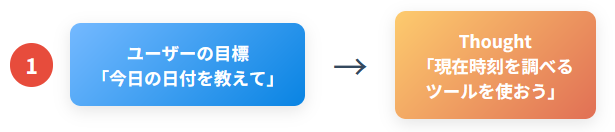

In [ ]:
# @title
# LLMに思考と行動を生成させる
# このセルを実行すると、LLMの応答がリアルタイムで表示されます
llm_response_1 = stream_llm_completion(
    prompt_cycle_1,
    max_tokens=200,
    stop=["Observation:"],
    temperature=0.01,
    show_input=False
)

### 👨‍💻サイクル2：外部ツールを実行し、結果を LLM に与える

LLMは `Action: get_current_datetime[]` と出力したはずです。今度はあなたがその指示に従い、`get_current_datetime()`関数を実行します。そして、その結果を`Observation:`として記録し、次のサイクルでLLMに渡すための新しいプロンプトを組み立てます。

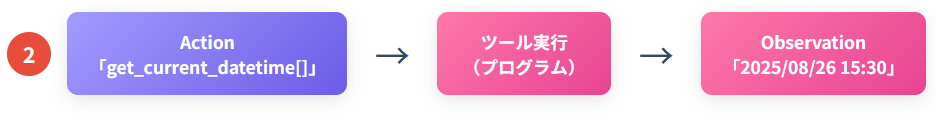

In [ ]:
# @title
# LLMの応答からAction部分を抜き出す
action_match = re.search(r"Action: (.*?)(?:\n|$)", str(llm_response_1))
tool_name = action_match.group(1).strip().split('[')[0]

# ツールを実行し、観察結果を得る
if tool_name in available_tools:
    observation = available_tools[tool_name]()
    print(f"✅ ツール '{tool_name}' を実行しました。")
    print(f"--- 観察結果 ---\n{observation}")
else:
    observation = f"エラー: 不明なツール '{tool_name}' が指定されました。"
    print(observation)

**課題🗓️：**

以下のテキストセルの日時を、上記のツールで得たものに差し替えて、続きを実行してください。

In [ ]:
# @markdown 上記の出力をここにコピペしてください
output_from_above = "" # @param {"type":"string"}

if output_from_above == "":
    print("入力されていません")
else:
    # 次のサイクルで使うプロンプトを組み立てる
    prompt_cycle_2 = prompt_cycle_1 + llm_response_1 + "\nObservation:" + output_from_above

    print("\n---【サイクル2でLLMに渡す、情報が追加されたプロンプト】---")
    print(prompt_cycle_2)

### 🎯サイクル3：外部ツールの結果をもとに LLM が最終回答を得る

あなたが与えた観察結果（`Observation`）を含む、より情報量の多いプロンプトを再度LLMに渡します。LLMは、この新しい情報を元に、最終的な答えを導き出すはずです。

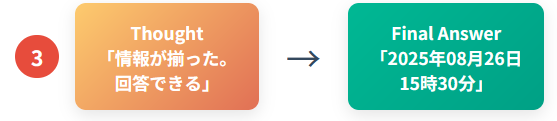

In [ ]:
# @title
# 成長したプロンプトをLLMに渡し、最終回答を生成させる
final_response = stream_llm_completion(
    prompt_cycle_2,
    max_tokens=200,
    temperature=0.01,
    show_input=False
)

print("\n\n🎉 ReActエージェントのタスクが完了しました！")

## 💡 おわりに：本格的なAIエージェント開発

さて、あなたは今、手動でReActのループを回し、見事にAIエージェントを動かすことができました。この手動のプロセスは、仕組みを理解する上で非常に重要です。

しかし、すでに複雑なコードとなっていて、もっと実用的なエージェントの開発を進めるのは難しそうです。実際の開発現場では、このプロセスをどのように効率化・高度化しているのでしょうか？

### ⚡ フレームワーク
私たちが手動で行った一連の作業は、ツールが一つや二つなら管理できますが、数十個のツールを扱ったり、より複雑な思考サイクルを回したりしようとすると、すぐに限界が来ます。そのようなAIエージェント開発における面倒な部分を肩代わりしてくれる便利なツールがあり、AI エージェント開発用の **フレームワーク** とよばれます。

フレームワークが提供する主な機能：
-   **プロンプト管理**: 私たちが書いた長大なテンプレートは、フレームワーク側で最適化されたものが用意されており、自分で管理する必要がありません。
-   **実行ループの自動化**: 何度も繰り返して検索するような場合もありますが、「Agent Executor」と呼ばれる機能が完全に自動で実行してくれます。
-   **ツールのエコシステム**: Web 検索、電卓、データベース接続など、あらかじめ用意された便利なツール群が揃っており、すぐに利用できます。
-   **応答の解析**: LLM の出力から`Action`や`Final Answer`を正確に抜き出す、高性能なパーサー（解析機能）を備えています。

#### 具体的なツール紹介

-   **LangChain / LangGraph 🦜🔗**
    -   **プログラマー向けのライブラリ**です。AIエージェントを構築するための豊富な部品（コンポーネント）を提供し、開発者がそれらを自由に組み合わせて、非常に柔軟でカスタム性の高いエージェントをPythonコードで構築できます。特に`LangGraph`は、単純なループだけでなく、より複雑な条件分岐や人の承認を挟むなど、自由な「思考の流れ（グラフ）」を設計できる新しい仕組みです。

-   **Dify [※教育版無料](https://dify.ai/jp/education) ✨**
    -   **LLMOps プラットフォーム**と呼ばれる、より統合された開発環境です。プログラミングの知識があまりなくても、ウェブ画面上で視覚的にLLMやプロンプト、ツールを繋ぎ合わせることで、AIアプリケーションやエージェントを迅速に構築できます（ローコード／ノーコード）。プロトタイピングや、非エンジニアも含むチームでの開発に向いています。

あなたがこの課題で学んだ「思考」「行動」「観察」という概念は、これらの本格的なフレームワークが内部で行っていることと全く同じです。この基本を理解したことで、あなたは今後、これらの高度なツールを使う際にも、その裏側で何が起きているのかを深く理解しながら、より強力なAIエージェントを開発していくことができるでしょう。

### 次のステップ

